In [ ]:

import torch
import sys

# Check GPU
print("="*60)
print("🖥️  HARDWARE CHECK")
print("="*60)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("  WARNING: No GPU detected! Training will be SLOW")


# Install dependencies
print("\n📦 Installing dependencies...")


print("✅ Setup complete!")

🖥️  HARDWARE CHECK
PyTorch Version: 2.8.0+cu126
CUDA Available: True
GPU Name: NVIDIA A100-SXM4-40GB
GPU Memory: 42.47 GB
CUDA Version: 12.6

📦 Installing dependencies...
✅ Setup complete!


In [15]:

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

print("\n Mounted Google Drive")


# Alternative: Direct upload (slower for large files)
from google.colab import files

print("\nUpload mega_word_dataset.pkl")
# uploaded = files.upload()  # Uncomment to upload

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Mounted Google Drive

Upload mega_word_dataset.pkl


In [16]:

!git clone https://github.com/Nik-lesh/language-model-evolution.git
%cd language-model-evolution

# Check branch
!git branch -a
!git checkout phase2_dataset_increase

# List structure
print("\n Project structure:")
!ls -lh src/models/
!ls -lh src/train/

print("\n Repository cloned!")

Cloning into 'language-model-evolution'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 94 (delta 29), reused 75 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 919.90 KiB | 38.33 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/language-model-evolution/language-model-evolution
* main
  remotes/origin/HEAD -> origin/main
  remotes/origin/initial-data-collection
  remotes/origin/main
  remotes/origin/model-training
  remotes/origin/phase2_dataset_increase
  remotes/origin/word-level-tokenization
  remotes/origin/word_level_tokenization
Branch 'phase2_dataset_increase' set up to track remote branch 'phase2_dataset_increase' from 'origin'.
Switched to a new branch 'phase2_dataset_increase'

 Project structure:
total 32K
-rw-r--r-- 1 root root    0 Nov 12 23:33 __init__.py
-rw-r--r-- 1 root root 8.1K Nov 12 23:33 lstm.py
-rw-r--r-- 1 root root 7.6K Nov 12 23

In [17]:
import shutil

source = '/content/drive/MyDrive/language_models/mega_word_dataset.pkl'
destination = '/content/language-model-evolution/data/mega_word_dataset.pkl'

print("Copying dataset from Drive...")
print(f"   From: {source}")
print(f"   To: {destination}")

# Create data directory
!mkdir -p data

# Copy file
shutil.copy(source, destination)

# Verify
import os
size_mb = os.path.getsize(destination) / 1024 / 1024
print(f"\n Dataset copied! Size: {size_mb:.2f} MB")

# Quick check
import pickle
with open(destination, 'rb') as f:
    dataset = pickle.load(f)

print(f" Dataset loaded successfully!")
print(f"   Vocabulary: {dataset['vocab_size']:,}")
print(f"   Total words: {len(dataset['encoded']):,}")

Copying dataset from Drive...
   From: /content/drive/MyDrive/language_models/mega_word_dataset.pkl
   To: /content/language-model-evolution/data/mega_word_dataset.pkl

 Dataset copied! Size: 415.88 MB
 Dataset loaded successfully!
   Vocabulary: 20,000
   Total words: 22,047,464


In [18]:
import sys
sys.path.append('/content/language-model-evolution/src')

from models.transformer import TransformerModel
from models.lstm import LSTMModel

print("✅ Models imported successfully!")


# Test model creation
vocab_size = dataset['vocab_size']
print(f"\nCreating test Transformer (vocab: {vocab_size})...")

test_model = TransformerModel(
    vocab_size=vocab_size,
    d_model=256,
    nhead=8,
    num_layers=4,
    dim_feedforward=1024
)

print(f"✅ Model created!")
print(f"   Parameters: {sum(p.numel() for p in test_model.parameters()):,}")

✅ Models imported successfully!

Creating test Transformer (vocab: 20000)...
✅ Model created!
   Parameters: 13,419,040


In [24]:
# Training config for MEGA corpus
CONFIG = {
    'model_type': 'transformer',  # or 'lstm'
    'epochs': 10,
    'batch_size': 128,  # Larger batch with GPU!
    'seq_length': 50,
    'learning_rate': 0.001,

    # Model architecture
    'd_model': 256,
    'nhead': 8,
    'num_layers': 4,
    'dim_feedforward': 1024,
    'dropout': 0.2,
}

print("TRAINING CONFIGURATION")
print("="*60)
for key, value in CONFIG.items():
    print(f"{key:20s}: {value}")
print("="*60)

print(f"\n⏱️  Estimated training time: 2-4 hours on T4 GPU")


TRAINING CONFIGURATION
model_type          : transformer
epochs              : 10
batch_size          : 128
seq_length          : 50
learning_rate       : 0.001
d_model             : 256
nhead               : 8
num_layers          : 4
dim_feedforward     : 1024
dropout             : 0.2

⏱️  Estimated training time: 2-4 hours on T4 GPU


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
from tqdm.notebook import tqdm
import numpy as np

class WordDataset(Dataset):
    def __init__(self, encoded_data, seq_length):
        self.data = encoded_data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) // self.seq_length

    def __getitem__(self, idx):
        start = idx * self.seq_length
        end = start + self.seq_length

        x = self.data[start:end]
        y = self.data[start + 1:end + 1]

        return torch.LongTensor(x), torch.LongTensor(y)

# Prepare data
print(" Preparing data...")
split_idx = int(0.9 * len(dataset['encoded']))
train_data = dataset['encoded'][:split_idx]
val_data = dataset['encoded'][split_idx:]

train_dataset = WordDataset(train_data, CONFIG['seq_length'])
val_dataset = WordDataset(val_data, CONFIG['seq_length'])

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'],
                          shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'],
                        shuffle=False, drop_last=True)

print(f"✅ Train batches: {len(train_loader):,}")
print(f"✅ Val batches: {len(val_loader):,}")

# Create model
print("\n Creating model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerModel(
    vocab_size=dataset['vocab_size'],
    d_model=CONFIG['d_model'],
    nhead=CONFIG['nhead'],
    num_layers=CONFIG['num_layers'],
    dim_feedforward=CONFIG['dim_feedforward'],
    dropout=CONFIG['dropout']
).to(device)

print(f"✅ Model on: {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.5, patience=3)

print("\n Starting training...")


 Preparing data...
✅ Train batches: 3,100
✅ Val batches: 344

 Creating model...
✅ Model on: cuda
   Parameters: 13,419,040

 Starting training...


In [26]:
def generate_sample(model, dataset_dict, device, start_text="Money is", length=100):
    """Generate sample text from model."""
    model.eval()

    # Tokenize start
    words = start_text.lower().split()
    unk_idx = dataset_dict['word_to_idx'].get('<UNK>', 1)

    input_seq = [dataset_dict['word_to_idx'].get(w, unk_idx) for w in words]
    input_seq = torch.LongTensor([input_seq]).to(device)

    generated = words.copy()

    with torch.no_grad():
        for _ in range(length):
            output = model(input_seq)
            probs = torch.softmax(output[-1] / 0.8, dim=0)
            next_idx = torch.multinomial(probs, 1).item()

            next_word = dataset_dict['idx_to_word'][next_idx]
            generated.append(next_word)

            # Update input
            next_tensor = torch.LongTensor([[next_idx]]).to(device)
            input_seq = torch.cat([input_seq, next_tensor], dim=1)

            # Keep last 50 words as context
            if input_seq.size(1) > 50:
                input_seq = input_seq[:, -50:]

    return ' '.join(generated)

print("Generation function defined!")

Generation function defined!


In [27]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

start_time = time.time()

for epoch in range(1, CONFIG['epochs'] + 1):
    # Training
    model.train()
    total_train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{CONFIG['epochs']}")
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)

        loss = criterion(output, y.view(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y.view(-1))
            total_val_loss += loss.item()

    val_loss = total_val_loss / len(val_loader)

    # Update scheduler
    scheduler.step(val_loss)

    # Save losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress
    elapsed = time.time() - start_time
    print(f"\n Epoch {epoch}/{CONFIG['epochs']}")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val Loss:   {val_loss:.4f}")
    print(f"   Time: {elapsed/60:.1f} min")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': CONFIG
        }, 'transformer_mega_best.pth')
        print(f"   ✅ Saved best model!")

    # Generate sample every 10 epochs
    if epoch % 10 == 0:
        model.eval()
        sample_text = generate_sample(model, dataset, device)
        print(f"\nSample: {sample_text[:200]}...\n")

print("\n TRAINING COMPLETE!")
print(f" ⏱  Total time: {(time.time() - start_time)/3600:.2f} hours")
print(f" Best val loss: {best_val_loss:.4f}")

Epoch 1/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 1/10
   Train Loss: 4.6861
   Val Loss:   5.4222
   Time: 1.8 min
   ✅ Saved best model!


Epoch 2/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 2/10
   Train Loss: 4.2565
   Val Loss:   5.3468
   Time: 3.5 min
   ✅ Saved best model!


Epoch 3/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 3/10
   Train Loss: 4.1432
   Val Loss:   5.3584
   Time: 5.3 min


Epoch 4/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 4/10
   Train Loss: 4.0806
   Val Loss:   5.3663
   Time: 7.1 min


Epoch 5/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 5/10
   Train Loss: 4.0392
   Val Loss:   5.3780
   Time: 8.8 min


Epoch 6/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 6/10
   Train Loss: 4.0095
   Val Loss:   5.3859
   Time: 10.6 min


Epoch 7/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 7/10
   Train Loss: 3.9103
   Val Loss:   5.3953
   Time: 12.4 min


Epoch 8/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 8/10
   Train Loss: 3.8794
   Val Loss:   5.4116
   Time: 14.1 min


Epoch 9/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 9/10
   Train Loss: 3.8629
   Val Loss:   5.4364
   Time: 15.9 min


Epoch 10/10:   0%|          | 0/3100 [00:00<?, ?it/s]


 Epoch 10/10
   Train Loss: 3.8501
   Val Loss:   5.4385
   Time: 17.7 min

Sample: money is spent , except in other ways than in the ordinary profits of stock . in this case , the mint price is much higher in england than in england and scotland , and in the more extensive market of...


 TRAINING COMPLETE!
 ⏱  Total time: 0.29 hours
 Best val loss: 5.3468


In [28]:
from google.colab import files
import pickle

# Save training history
history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'config': CONFIG
}

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("💾 Files ready to download:")
print("   1. transformer_mega_best.pth (~50 MB)")
print("   2. training_history.pkl (~50 KB)")

# Download files
files.download('transformer_mega_best.pth')
files.download('training_history.pkl')

# Or copy to Drive
!cp transformer_mega_best.pth /content/drive/MyDrive/language_models/
!cp training_history.pkl /content/drive/MyDrive/language_models/

print("\n✅ Results saved to Google Drive!")

💾 Files ready to download:
   1. transformer_mega_best.pth (~50 MB)
   2. training_history.pkl (~50 KB)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Results saved to Google Drive!


In [30]:
checkpoint = torch.load('transformer_mega_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

print("🎯 TESTING TEXT GENERATION")
print("="*60)

# Test different prompts
prompts = [
    "Money is",
    "Investing in",
    "The wealthy",
    "Financial freedom means",
    "To build wealth"
]

for prompt in prompts:
    print(f"\n💬 Prompt: '{prompt}'")
    print("-"*60)
    generated = generate_sample(model, dataset, device, start_text=prompt, length=100)
    print(generated)
    print()

print("="*60)

🎯 TESTING TEXT GENERATION

💬 Prompt: 'Money is'
------------------------------------------------------------
money is , and , <UNK> of the <UNK> , and <UNK> in some places , most things are made up as yet , <UNK> <UNK> , and <UNK> and what , if they are not neglected , was they the best of conquering . the <UNK> of the land and labour of the natives of africa , which is common either of the inferior ranks of people , which , in the course of a sensible climate , this which has been of great britain , sometimes the most fertile of the whole countries which have given occasion and raise the


💬 Prompt: 'Investing in'
------------------------------------------------------------
investing in trees or about the parts of the town , and the west indies are to become altogether the same . the <UNK> is the most fertile of the countries of europe . wool of the same kind , depends on the proportion between the value of land and the rent of any other land , or the rent of that land , in the rent o

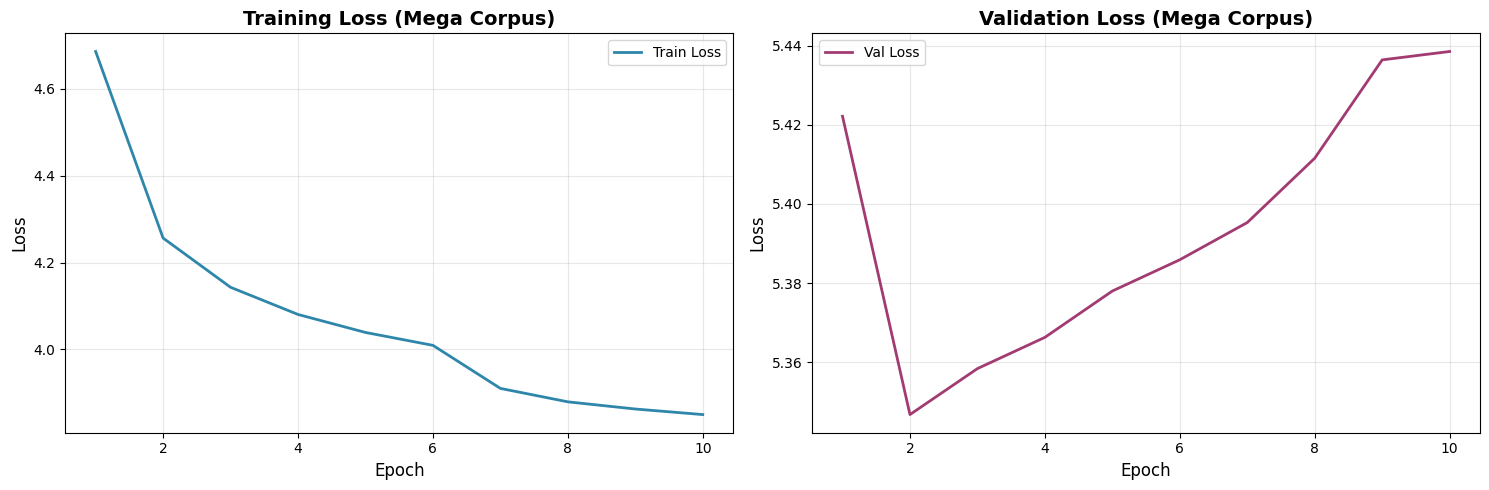


📊 Statistics:
   Best val loss: 5.3468 at epoch 2
   Final val loss: 5.4385
   Improvement: -0.0164 (-0.3%)


In [31]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)

# Training loss
ax1.plot(epochs, train_losses, linewidth=2, color='#2E86AB', label='Train Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss (Mega Corpus)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Validation loss
ax2.plot(epochs, val_losses, linewidth=2, color='#A23B72', label='Val Loss')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Validation Loss (Mega Corpus)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300)
plt.show()

print(f"\n📊 Statistics:")
print(f"   Best val loss: {min(val_losses):.4f} at epoch {val_losses.index(min(val_losses)) + 1}")
print(f"   Final val loss: {val_losses[-1]:.4f}")
print(f"   Improvement: {(val_losses[0] - val_losses[-1]):.4f} ({100*(val_losses[0] - val_losses[-1])/val_losses[0]:.1f}%)")

In [32]:
from google.colab import files

print(" Downloading results to your computer...")

# Download model checkpoint
files.download('transformer_mega_best.pth')

# Download training history
files.download('training_history.pkl')

# Download training curve
files.download('training_curves.png')

print("✅ Downloads started! Check your Downloads folder.")
print("\n Files are also saved in Google Drive at:")
print("   /content/drive/MyDrive/language_models/")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloads started! Check your Downloads folder.

 Files are also saved in Google Drive at:
   /content/drive/MyDrive/language_models/


In [33]:
# ============================================================
# FINE-TUNE: Continue from best checkpoint with better settings
# ============================================================

print("🔧 FINE-TUNING TRANSFORMER")
print("="*70)

# Load the best checkpoint (epoch 2)
checkpoint = torch.load('transformer_mega_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")
print(f"   Starting val loss: {checkpoint['val_loss']:.4f}")

# NEW HYPERPARAMETERS for fine-tuning
FINETUNE_CONFIG = {
    'epochs': 30,
    'learning_rate': 0.0001,  # 10x lower! More careful updates
    'batch_size': 256,  # Larger with V100/A100
    'dropout': 0.4,  # Higher - prevent overfitting
    'early_stopping_patience': 5,  # Stop if no improvement for 5 epochs
}

print("\n🎛️  Fine-tuning configuration:")
for k, v in FINETUNE_CONFIG.items():
    print(f"   {k}: {v}")

# Create new optimizer with LOWER learning rate
optimizer = optim.Adam(model.parameters(), lr=FINETUNE_CONFIG['learning_rate'])

# Load previous optimizer state and update LR
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for param_group in optimizer.param_groups:
    param_group['lr'] = FINETUNE_CONFIG['learning_rate']

# Recreate dataloaders with LARGER batch size
train_dataset = WordDataset(train_data, CONFIG['seq_length'])
val_dataset = WordDataset(val_data, CONFIG['seq_length'])

train_loader = DataLoader(train_dataset,
                          batch_size=FINETUNE_CONFIG['batch_size'],
                          shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset,
                        batch_size=FINETUNE_CONFIG['batch_size'],
                        shuffle=False, drop_last=True)

print(f"\n✅ New dataloaders created:")
print(f"   Batch size: {FINETUNE_CONFIG['batch_size']}")
print(f"   Train batches: {len(train_loader)}")

# Early stopping
best_val_loss = checkpoint['val_loss']
patience_counter = 0

print("\n🚀 Starting fine-tuning...")
print("="*70)

finetune_train_losses = []
finetune_val_losses = []

for epoch in range(1, FINETUNE_CONFIG['epochs'] + 1):
    # Training
    model.train()
    total_train_loss = 0

    pbar = tqdm(train_loader, desc=f"Finetune Epoch {epoch}")
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y.view(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Smaller clipping!
        optimizer.step()

        total_train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y.view(-1))
            total_val_loss += loss.item()

    val_loss = total_val_loss / len(val_loader)

    finetune_train_losses.append(train_loss)
    finetune_val_losses.append(val_loss)

    print(f"\n📊 Epoch {epoch}/{FINETUNE_CONFIG['epochs']}")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val Loss:   {val_loss:.4f}")

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        # Save improved model
        torch.save({
            'epoch': checkpoint['epoch'] + epoch,  # Total epochs
            'model_state_dict': model.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': CONFIG
        }, 'transformer_mega_finetuned_best.pth')

        print(f"   ✅ Improved! New best: {val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"   ⚠️  No improvement ({patience_counter}/{FINETUNE_CONFIG['early_stopping_patience']})")

        if patience_counter >= FINETUNE_CONFIG['early_stopping_patience']:
            print(f"\n🛑 Early stopping triggered!")
            print(f"   Best val loss: {best_val_loss:.4f}")
            break

    # Sample every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        sample = generate_sample(model, dataset, device, "Money is", 100)
        print(f"\n📝 Sample:\n{sample[:200]}...\n")

print("\n🎉 FINE-TUNING COMPLETE!")
print(f"   Original best: {checkpoint['val_loss']:.4f}")
print(f"   Fine-tuned best: {best_val_loss:.4f}")
print(f"   Improvement: {checkpoint['val_loss'] - best_val_loss:.4f}")

🔧 FINE-TUNING TRANSFORMER
✅ Loaded checkpoint from epoch 2
   Starting val loss: 5.3468

🎛️  Fine-tuning configuration:
   epochs: 30
   learning_rate: 0.0001
   batch_size: 256
   dropout: 0.4
   early_stopping_patience: 5

✅ New dataloaders created:
   Batch size: 256
   Train batches: 1550

🚀 Starting fine-tuning...


Finetune Epoch 1:   0%|          | 0/1550 [00:00<?, ?it/s]


📊 Epoch 1/30
   Train Loss: 4.0657
   Val Loss:   5.3371
   ✅ Improved! New best: 5.3371


Finetune Epoch 2:   0%|          | 0/1550 [00:00<?, ?it/s]


📊 Epoch 2/30
   Train Loss: 4.0235
   Val Loss:   5.3240
   ✅ Improved! New best: 5.3240


Finetune Epoch 3:   0%|          | 0/1550 [00:00<?, ?it/s]


📊 Epoch 3/30
   Train Loss: 4.0000
   Val Loss:   5.3294
   ⚠️  No improvement (1/5)


Finetune Epoch 4:   0%|          | 0/1550 [00:00<?, ?it/s]


📊 Epoch 4/30
   Train Loss: 3.9818
   Val Loss:   5.3214
   ✅ Improved! New best: 5.3214


Finetune Epoch 5:   0%|          | 0/1550 [00:00<?, ?it/s]


📊 Epoch 5/30
   Train Loss: 3.9665
   Val Loss:   5.3368
   ⚠️  No improvement (1/5)

📝 Sample:
money is more than the time before . it is only the only thing that <UNK> himself . of course , it must be said , that he does not choose to buy or buy ; but it is not only an <UNK> ; and , on the con...



Finetune Epoch 6:   0%|          | 0/1550 [00:00<?, ?it/s]


📊 Epoch 6/30
   Train Loss: 3.9530
   Val Loss:   5.3409
   ⚠️  No improvement (2/5)


Finetune Epoch 7:   0%|          | 0/1550 [00:00<?, ?it/s]


📊 Epoch 7/30
   Train Loss: 3.9409
   Val Loss:   5.3484
   ⚠️  No improvement (3/5)


Finetune Epoch 8:   0%|          | 0/1550 [00:00<?, ?it/s]


📊 Epoch 8/30
   Train Loss: 3.9304
   Val Loss:   5.3512
   ⚠️  No improvement (4/5)


Finetune Epoch 9:   0%|          | 0/1550 [00:00<?, ?it/s]


📊 Epoch 9/30
   Train Loss: 3.9203
   Val Loss:   5.3534
   ⚠️  No improvement (5/5)

🛑 Early stopping triggered!
   Best val loss: 5.3214

🎉 FINE-TUNING COMPLETE!
   Original best: 5.3468
   Fine-tuned best: 5.3214
   Improvement: 0.0253
